# No Fuss DML

Implementation of NCA Loss for Distance metric learning using Keras form : https://arxiv.org/pdf/1703.07464.pdf
Already applied it to various datasets, found it very useful especially when it's hard to mine hard negatives or triplets size is outrageously large.

The technique can produce high quality embeddings

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, Lambda, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.layers.embeddings import Embedding
from keras import backend as K
import numpy as np
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [10]:
img_rows, img_cols = 28, 28
batch_size = 128
num_classes = 10
epochs = 5
embedding_size = 64
vis_sample_size = 100

the data, shuffled and split between train and test sets

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Pre process data

In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


## Model

We will have two models one for training, the other to compute the embeddings (the useful one; just diffirent inputs/outputs and without proxy_layer)

In [5]:
inp_x = Input(shape=(28,28,1))
inp_y = Input(shape=(1,))

# Class proxy
proxies_layer = Embedding(num_classes*2, embedding_size, name='emb_proxies', embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3, seed=7))
proxies_output = proxies_layer(inp_y)
proxies_output = Reshape((embedding_size,))(proxies_output)

# Conv network
x = Conv2D(32, kernel_size=(3, 3),
        activation='relu',
        input_shape=input_shape)(inp_x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
emb_img = Dense(embedding_size, activation='linear', name='embedding')(x)

#proxies_layer.trainable = False

# Training model
model = Model(inputs=[inp_x, inp_y], outputs=[emb_img])
to_be_used_model = Model(inputs=inp_x, outputs=emb_img)

## NCA Loss

Maybe there is a more idiomatic way to implement nca loss in Keras/Tensorflow
For more details about NCA look at http://www.cs.toronto.edu/~fritz/absps/nca.pdf

In [6]:
from keras import backend as K
import tensorflow as tf

def expand_multiple_dims(x, axes, name="expand_multiple_dims"):
  with tf.name_scope(name):
    for i in sorted(axes):
      x = tf.expand_dims(x, axis=i, name="expand_axis_%i" % i)
    return x


# Theano-like dimshuffle
def dimshuffle(x, axes, name="dimshuffle"):
  with tf.name_scope(name):
    assert all([i == "x" or isinstance(i, int) for i in axes])
    real_axes = [i for i in axes if isinstance(i, int)]
    bc_axes = [i for (i, j) in enumerate(axes) if j == "x"]
    if x.get_shape().ndims is None:
      x_shape = tf.shape(x)
      x = tf.reshape(x, [x_shape[i] for i in range(max(real_axes) + 1)])  # will have static ndims
    assert x.get_shape().ndims is not None

    # First squeeze missing axes.
    i = 0
    while i < x.get_shape().ndims:
      if i not in real_axes:
        x = tf.squeeze(x, axis=i)
        real_axes = [(j if (j < i) else (j - 1)) for j in real_axes]
      else:
        i += 1

    # Now permute.
    assert list(sorted(real_axes)) == list(range(x.get_shape().ndims))
    if real_axes != list(range(x.get_shape().ndims)):
      x = tf.transpose(x, real_axes)

    # Now add broadcast dimensions.
    if bc_axes:
      x = expand_multiple_dims(x, bc_axes)
    assert len(axes) == x.get_shape().ndims
    return x

def lookup(what, where, default=None):
    """Return ``where.what`` if what is a string, otherwise what. If not found
    return ``default``."""
    if isinstance(what, (str, unicode)):
        res = getattr(where, what, default)
    else:
        res = what
    return res


def l2(x, axis=None):    
    return tf.norm(x, axis=axis, ord=2, keep_dims=False)

def pairwise_diff(X, Y=None):
    Y = X if Y is None else Y    
    diffs = dimshuffle(K.transpose(X), (1, 0, 'x')) - dimshuffle(K.transpose(Y), ('x', 0, 1))    
    return diffs


def distance_matrix(X, Y=None, norm=l2):
    diff = pairwise_diff(X, Y)
    diff = distance_matrix_by_diff(diff, norm=norm)
    return diff


def distance_matrix_by_diff(diff, norm=l2):
    diff = norm(diff, axis=1)
    return diff

def diagonal(x):
    return tf.diag_part(x)

def normalize_rowwise(mat):  
    with tf.variable_scope("normalize_rowwise"):
        return mat / K.reshape(l2(mat,axis=1) + K.epsilon(), [-1,1])

def nca_loss(embeddings, proxies_output, proxies_weights): # proxies_weights = proxy embedding raw matrix
    """Return the NCA loss for No Fuss DML.
    For details, we refer you to 'Neighbourhood Component Analysis' by
    J Goldberger, S Roweis, G Hinton, R Salakhutdinov (2004).
    ----------
    """    
    embeddings_normed = normalize_rowwise(embeddings)    
    # Positive distances
    target_proxies_normed = normalize_rowwise(proxies_output)        
    positive_distances = diagonal(distance_matrix(target_proxies_normed, embeddings_normed))
    numerator = K.exp(-positive_distances) 
    # Negative distances    
    proxies_normed = normalize_rowwise(proxies_weights)    
    all_distances = distance_matrix(embeddings_normed, proxies_normed)        
    denominator = K.sum(K.exp(-all_distances), axis=1) - numerator        
    # Compute ratio
    loss_vector = -K.log(numerator) / (denominator+K.epsilon())
    loss = K.mean(loss_vector)
    return loss

def loss(y_true, y_pred):
    return  nca_loss(y_pred-0*y_true, proxies_output, proxies_layer.embeddings)

Compile the model, RMSprop as optimizer

In [7]:
model.compile(loss=loss,optimizer='adadelta')

In [8]:
model.fit([x_train, y_train], np.zeros((x_train.shape[0],1)),
          epochs=epochs,
          verbose=0,
          validation_data=([x_test, y_test], np.zeros((x_test.shape[0],1))),
          batch_size=batch_size,
          callbacks=[TQDMNotebookCallback(leave_inner=False)])

## Visualization

Project produced embeddings on 2D plan using T-SNE, you can also use TensorBoard faster T-SNE a possibility to visualize in 3D

Please this function will sample randomly a `vis_sample_size` points from test data. So yeah ! every time you will have different plot.

(If it's not already done, please do yourself a favor and go read about t-sne https://distill.pub/2016/misread-tsne/)

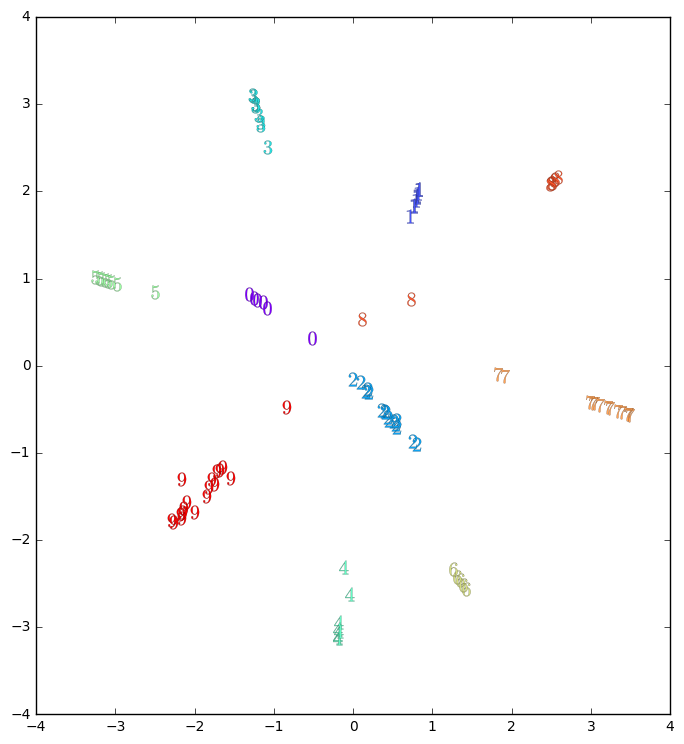

In [16]:
from sklearn.manifold import TSNE
from matplotlib.pyplot import cm
import scipy as sp
from scipy import ndimage
from scipy import misc
import matplotlib.pyplot as plt

def plot_embeddings(save=None):
    colors=cm.rainbow(np.linspace(0,1,num_classes))    
    sel = np.random.choice(x_test.shape[0], vis_sample_size, replace=False)
    valid_set, valid_labels = x_test[sel,:], y_test[sel]
    class_embeddings = np.array(to_be_used_model.predict(valid_set))


    class_embeddings = TSNE(n_components=2, perplexity=45, verbose=0, n_iter=5000, learning_rate=10).fit_transform(class_embeddings)

    plt.figure(figsize=(18,9))
    for cls, color in zip(range(num_classes),colors):
        current_points = class_embeddings[valid_labels==cls]
        if save is not None:
            plt.title('Iteration {}'.format(save))
        plt.subplot(121).scatter(current_points[:,0], current_points[:,1],
                    c=color, #valid_labels[valid_labels==cls],
                    marker='${}$'.format(cls), s=100, linewidths=0.1, edgecolor='black')       
    plt.legend()
    plt.show()
plot_embeddings()